# Movie Recommender System

##### Import Libraries

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

##### Loading Files

In [3]:
#To view the links file under the data folder
movie_links = pd.read_csv('Data\links.csv')
#To view the first 5 elements
movie_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
#To view the movies file under the data folder
movies_df = pd.read_csv('Data\movies.csv')
movies_df.head() #To view the first 5 elements

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#To load the ratings file under the data folder
rating_df = pd.read_csv('Data\\ratings.csv')
#To view the first 5 elements
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#To load the tags under the data folder
tags_df = pd.read_csv('Data\\tags.csv')
#To view the first 5 elements
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


##### Merge the Files

In [7]:
#Merge the movies to ratings table on movieid
merged_df = pd.merge(movies_df, rating_df, on='movieId')

# Display the first few rows of the merged DataFrame
merged_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


#### Inspecting the DataFrame

In [8]:
#To view the shape of the merged dataFrame
merged_df.shape

(100836, 6)

* We have 100,836 rows and 6 columns in our dataset

In [9]:
#To view the columns
merged_df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [10]:
#To view the information
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


* No null values from the dataset and we have 2 types of datatypes that is float64 and int64

In [11]:
#To view the statistical details of the dataframe
merged_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


* From above we note the max movieId:193,609, userId:610.00, min and max rating 0.5 and 5 respectively. 

##### Checking for null values 

In [12]:
#Check for null values
merged_df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

* No null values present on the dataframe

##### Checking for duplicates

In [15]:
#Check for duplicates from the merged_df
merged_df_cleaned = merged_df.drop_duplicates()
num_rows, num_columns = merged_df_cleaned.shape #obtain the number of rows and columns after removing duplicates
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 100836, Number of columns: 6


* No duplicate found as the number of rows and columns are as per the original shape of the dataframe

##### Rating Distribution Visualization

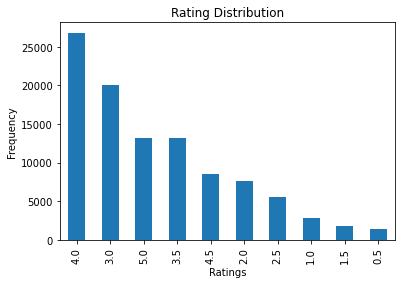

In [17]:
# Visualize distribution of ratings
merged_df_cleaned['rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

* Most movies are rated 4.0, 3.0 and 5.0 respectively. 

##### Movie Distribution

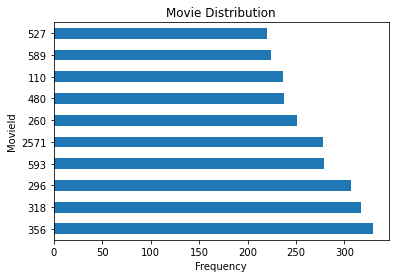

In [22]:
# Count occurrences of each movieId and get the top 10
top_movies = merged_df_cleaned['movieId'].value_counts().head(10)
# Visualize distribution of movies
top_movies.plot(kind='barh')
plt.title('Movie Distribution')
plt.xlabel('Frequency')
plt.ylabel('MovieId')
plt.show()

##### Genres Distribution

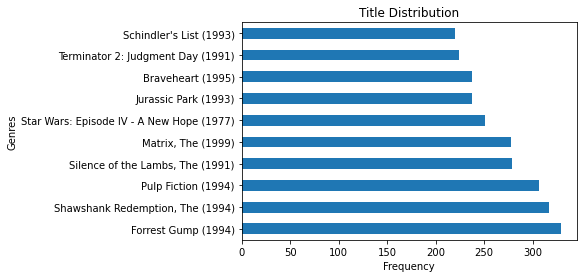

In [27]:
top_genres = merged_df_cleaned['title'].value_counts().head(10)
# Visualize distribution of movie titles
top_genres.plot(kind='barh')
plt.title('Title Distribution')
plt.xlabel('Frequency')
plt.ylabel('Genres')
plt.show()

##### UserId Distribution

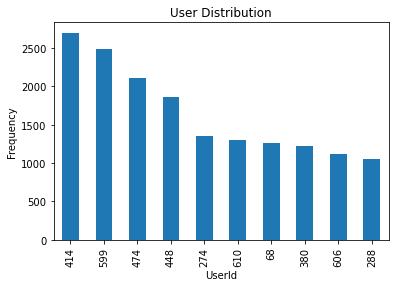

In [28]:
top_users = merged_df_cleaned['userId'].value_counts().head(10)
# Visualize distribution of Userid
top_users.plot(kind='bar')
plt.title('User Distribution')
plt.xlabel('UserId')
plt.ylabel('Frequency')
plt.show()

##### Collaborative Filtering

In [40]:
# Create a user-item matrix with ratings 
#Use the compressed sparse row (CSR) format. This is a memory-efficient 
user_item_matrix = csr_matrix((merged_df['rating'], (merged_df['userId'], merged_df['movieId'])))

* Here we have 610 users 

In [41]:
# Drop unnecessary columns and put the required columns movie, user and ratings into the new_df Dataframe
new_df = merged_df_cleaned.drop(['timestamp', 'title', 'genres'], axis=1)
reader = Reader()
data = Dataset.load_from_df(new_df,reader)
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  9724 

Number of items:  610


From the above number of users and items we note several concerns:
* The number of users significantly exceeds the number of items. If most users have rated only a small subset of the available items, the data becomes sparse. Sparse data can lead to unreliable recommendations since the model may not have enough information to accurately predict a user’s preferences.
* New users or items may not have enough interactions (ratings) to generate meaningful recommendations. 



##### Explore Matrix Factorization To reduce sparsity and capture latent factors in user-item interactions

In [42]:
## Perform a gridsearch with SVD
params = {'n_factors': [140, 90, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8731068232578897, 'mae': 0.6720605091910181}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


In [50]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

#Create user-item matrix using the new_df
user_item_matrix = csr_matrix((new_df['rating'], (new_df['userId'], new_df['movieId'])))

# Calculate cosine similarity
# user_similarity = cosine_similarity(user_item_matrix)

<611x193610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [53]:
# Create a user-item matrix
# user_item_matrix = csr_matrix((new_df['rating'], (new_df['userId'], new_df['movieId'])))

user_item_matrix = new_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the DataFrame to a sparse matrix
user_item_sparse = csr_matrix(user_item_matrix.values)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_sparse)

# Convert to DataFrame for easier handling
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Display the user similarity matrix
print("User Similarity Matrix:")
print(user_similarity_df)

# Function to get top N similar users
def get_top_n_similar_users(user_id, n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).head(n)
    return similar_users

# Example usage
user_id = 1
top_similar_users = get_top_n_similar_users(user_id)
print(f"\nTop {top_similar_users.size} users similar to User {user_id}:")
print(top_similar_users)

User Similarity Matrix:
userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   
...          ...       ...       ...       ...       ...       ...       ...   
606     0.164191  0.028429  0.012993  0.200395  0.106435  0.102123  0.200035   
607     0.269389  0.012948  0.019247  0.131746  0.152866  0.162182  0.186114   
608     0.291097  0.046211  0.021128  0.149858  0.135535  0.178809  0.323541   
609     0.093572  0.027565  0.000000  0.032198  0.261232  0.214234  0.090840   
610     0.145321